In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial

import wolff

# Track calculation errors
np.seterr('raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [7]:
path = '/Users/s3182541/STSP/Decoding/data/'
mem1_file = 'neuro_mem3.npy'
# mem2_file = 'neuro_mem2_2.npy'
angles_file = 'initial_angles_cued3.npy'

In [3]:
mem_data1 = np.load(path + mem1_file) # trials by timesteps by neurons

<IPython.core.display.Javascript object>


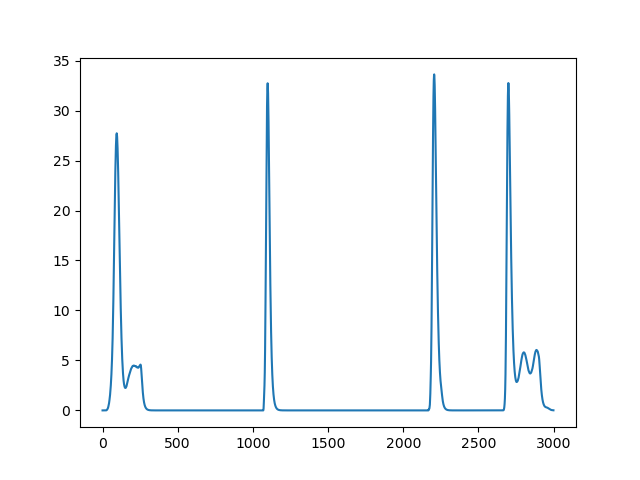

In [4]:
plt.close()

meaned1 = np.mean(np.mean(mem_data1, 0), 1)
plt.plot(meaned1)
plt.show()

In [32]:
mem_data2 = np.load(path + mem2_file)

<IPython.core.display.Javascript object>


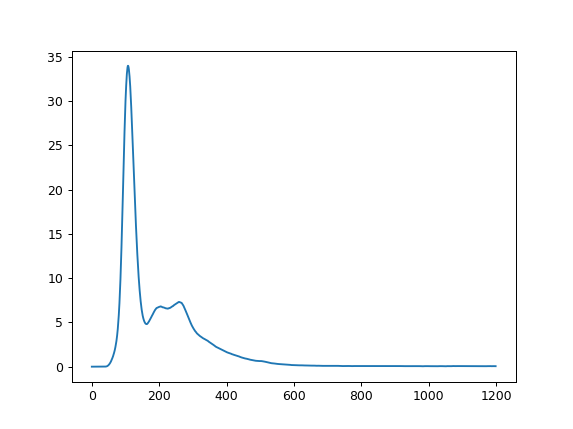

In [33]:
plt.close()

meaned2 = np.mean(np.mean(mem_data2, 0), 1)
plt.plot(meaned2)
plt.show()

In [8]:
angles = np.load(path + angles_file)
# Convert to radians
angles = angles / 360 * 2 * np.pi
# 'Scale' the angles
angles *= 2

In [9]:
def group(mem_data):
    cut_data = mem_data[:, :500, :] # trials by 500 by neurons
    num_channels = 17
    neurons = np.mean(cut_data, 1).T # neurons by trials
    kmeans = KMeans(n_clusters=num_channels, n_init=20, n_jobs=10, tol=1e-20).fit(neurons)
    
    data = np.empty((mem_data.shape[0], num_channels, mem_data.shape[1])) # trials by num_channels by timesteps
    for channel in range(num_channels):
        clear_output(wait=True)
        print(str(channel + 1) + "/" + str(num_channels))
        data[:, channel, :] = np.mean(mem_data[:, :, kmeans.labels_ == channel], axis=2)
        
    return data

In [10]:
data1 = group(mem_data1)

17/17


In [36]:
data2 = group(mem_data2)

17/17


In [11]:
# Add noise to prevent division by zero errors in covdiag()
data1 += np.random.normal(scale=0.5, size=data1.shape)

In [ ]:
# Add noise to prevent division by zero errors in covdiag()
data2 += np.random.normal(scale=0.5, size=data2.shape)

In [12]:
bin_width = np.pi / 6
angspace = np.arange(-np.pi, np.pi, bin_width) # with 'scaled' angles
# angspace = np.arange(-0.5*np.pi, 0.5*np.pi+bin_width, bin_width)

if __name__ == '__main__':
    (cos_amp1, distances1) = wolff.similarity_p(data1, angles, angspace, bin_width, num_cores=40)

In [ ]:
if __name__ == '__main__':
    (cos_amp2, distances2) = wolff.similarity_p(data2, angles, angspace, bin_width, num_cores=40)

<IPython.core.display.Javascript object>


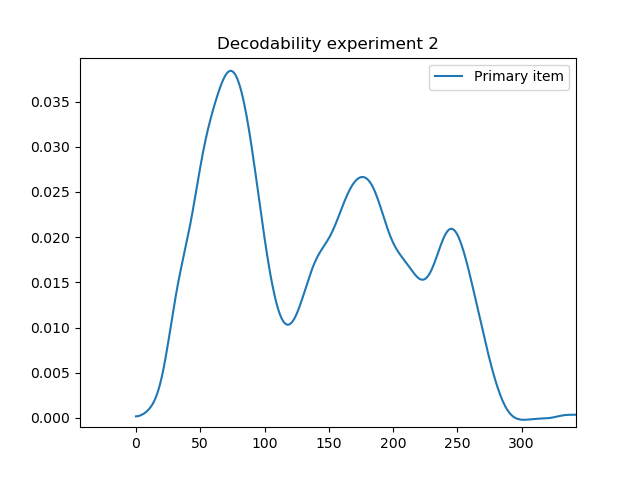

In [15]:
plt.close()

cos_amp_filtered1 = gaussian_filter(np.mean(cos_amp1, axis=0), sigma=8)
# cos_amp_filtered2 = gaussian_filter(np.mean(cos_amp2, axis=0), sigma=8)
# cos_amp_filtered = np.mean(cos_amp, axis=0)

plt.title("Decodability experiment 2")

plt.plot(cos_amp_filtered1, label='Primary item')
# plt.plot(cos_amp_filtered2, label='Secondary item')
# plt.plot(meaned / 35 * 0.05)

plt.legend()

plt.show()

<IPython.core.display.Javascript object>


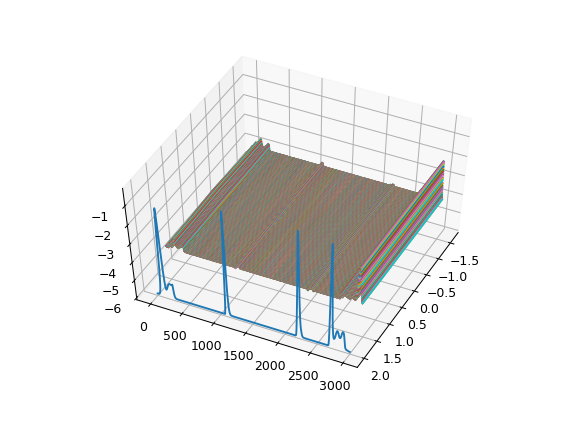

In [52]:
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(3000):
    ax.plot(angspace, angspace.shape[0]*[i], -np.mean(distances[:, :, i], 0))
    
ax.plot(distances.shape[2]*[2], range(distances.shape[2]), meaned / 35 * 6 - 6)

# for i in range(100):
#     ax.plot(angspace, angspace.shape[0]*[i], -np.mean(distances[:, :, i+800], 0))
    
# ax.plot(100*[2], range(100), (meaned / 35 * 6 - 6)[800:900])
    
# ax = fig.add_subplot(122)
# ax.plot(np.mean(cos_amp, 0))

plt.show()